# The task
- Use `DeepLabV3` model for Semantic Segmentation of humans in the image.
- Create a class with at least one method - predict_mask(path_input). This method should return a segmentation mask.

`path_input` is a parameter to set a path to the input image.
Note:

- Only humans should be masked.
- It would be a plus if you also write a method to visualize the result of
segmentation (map your mask on image).

## Setup Environment

In [7]:
import cv2
import numpy as np
import torch
import torchvision

import matplotlib.pyplot as plt
import matplotlib

from PIL import Image

## Semantic Segmentation Class

In [2]:
class SemanticSegm:
    """
    This class helps to make predictions of mask and to visualize them (map mask on image) with DeepLabV3 model
    """
    def __init__(self):
        self.model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.transform = torchvision.transforms.Compose([ 
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
            ])
        self.final_img = np.zeros((720, 1280, 3))
        

    def get_segment_labels(self, image):
      image = self.transform(image).to(self.device)
      image = image.unsqueeze(0)
      outputs = self.model(image)
      return outputs

    def draw_segmentation_map(self, outputs):
      labels = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()

      red_map = np.zeros_like(labels).astype(np.uint8)
      green_map = np.zeros_like(labels).astype(np.uint8)
      blue_map = np.zeros_like(labels).astype(np.uint8)

      index = labels == 15 # person class is index 15
      red_map[index] = 192
      green_map[index] = 128
      blue_map[index] = 128
    
      segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
      return segmentation_map

    def image_overlay(self, image, segmented_image):
      alpha = 1 # transparency for the original image
      beta = 0.9 # transparency for the segmentation map
      gamma = 0 # scalar added to each sum

      segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
      image = np.array(image)
      image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
      cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
      return image


    def predict_mask(self, path_input):
        self.img_path = path_input
        self.model.eval().to(self.device)
        image = Image.open(path_input)
        outputs = self.get_segment_labels(image)
        
        outputs = outputs['out']
        segmented_image = self.draw_segmentation_map(outputs)

        self.final_img = self.image_overlay(image, segmented_image)

    def visualize_mask(self):
        matplotlib.rcParams['figure.figsize'] = 12, 9
        plt.imshow(self.final_img)
        plt.axis('off')
        plt.show()

In [3]:
s = SemanticSegm()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

In [5]:
s.predict_mask('/content/dogs_women.jpg')

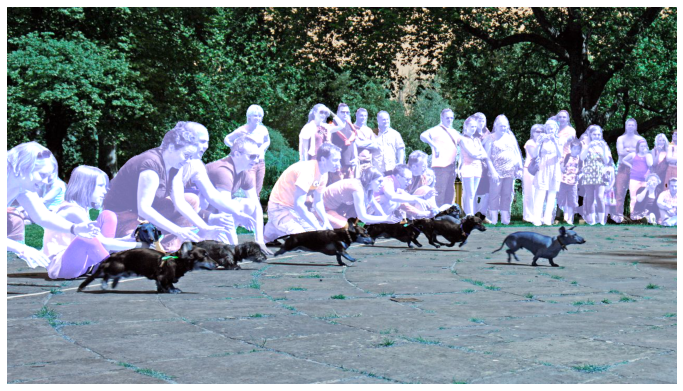

In [8]:
s.visualize_mask()